In [1]:
# ------------------------------------------------
# 
# sil vs cc data, plotting the initial R for both
# runs then taking the difference between the two
# 
# (note, takes
# files that were generated in the scratch/cdr_
# ...feedstock_compare-apprate+psize.ipynb file)
# 
# ------------------------------------------------
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for custom legend entries (needed for contour plot)
import cmocean.cm as cmo
import pickle
import os
import re
import glob
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


# set data path
datpath = "/home/tykukla/aglime-swap-cdr/scepter/process/runs/batch_postprocResults/cc-sil_psize_apprate"

# --- select which data to read in 
# FERT LEVEL 1 
fertLevel_1 = "hi"
idx_1 = "001" # [(no tag): 009=0.2 ton cc/ha/yr; 012=0.5 ton cc/ha/yr; 002=0.8 ton cc/ha/yr; 011=1.4 ton cc/ha/yr] 
tag_sil_1 = "basev12" # "basev3_multiCTRL"

# FERT LEVEL 2
fertLevel_2 = "low"
idx_2 = "001" # [(no tag): 009=0.2 ton cc/ha/yr; 012=0.5 ton cc/ha/yr; 002=0.8 ton cc/ha/yr; 011=1.4 ton cc/ha/yr] 
tag_sil_2 = "basev12"   # "basev3_multiCTRL"

In [2]:
# ---- READ IN DATA
# CASE 1 
datdir_1 = f"meanAnn_shortRun_{fertLevel_1}Fert_{tag_sil_1}_{idx_1}"    
datloc_1 = os.path.join(datpath, datdir_1)
# read in xr datasets
dssil1 = xr.open_dataset(os.path.join(datloc_1, 'ds_sil.nc'))
dscc1 = xr.open_dataset(os.path.join(datloc_1, 'ds_cc.nc'))
ds_anom1 = xr.open_dataset(os.path.join(datloc_1, 'ds_anom.nc'))
# # read in profile data
# dssil1_v1 = xr.open_dataset(os.path.join(datloc_1, f"{varin1}_{dustsp_sil}_{varsuff}.nc"))
# dscc1_v1 = xr.open_dataset(os.path.join(datloc_1, f"{varin1}_{dustsp_cc}_{varsuff}.nc"))
# dssil1_v2 = xr.open_dataset(os.path.join(datloc_1, f"{varin2}_{dustsp_sil}_{varsuff}.nc"))
# dscc1_v2 = xr.open_dataset(os.path.join(datloc_1, f"{varin2}_{dustsp_cc}_{varsuff}.nc"))

# CASE 2
datdir_2 = f"meanAnn_shortRun_{fertLevel_2}Fert_{tag_sil_2}_{idx_2}"    
datloc_2 = os.path.join(datpath, datdir_2)
# read in xr datasets
dssil2 = xr.open_dataset(os.path.join(datloc_2, 'ds_sil.nc'))
dscc2 = xr.open_dataset(os.path.join(datloc_2, 'ds_cc.nc'))
ds_anom2 = xr.open_dataset(os.path.join(datloc_2, 'ds_anom.nc'))
# # read in profile data
# dssil2_v1 = xr.open_dataset(os.path.join(datloc_2, f"{varin1}_{dustsp_sil}_{varsuff}.nc"))
# dscc2_v1 = xr.open_dataset(os.path.join(datloc_2, f"{varin1}_{dustsp_cc}_{varsuff}.nc"))
# dssil2_v2 = xr.open_dataset(os.path.join(datloc_2, f"{varin2}_{dustsp_sil}_{varsuff}.nc"))
# dscc2_v2 = xr.open_dataset(os.path.join(datloc_2, f"{varin2}_{dustsp_cc}_{varsuff}.nc"))


## Script to make a 6 panel figure in two parts

**Part 1:** (4 panels) Basalt and aglime $R$ for hi and low acidity scenarios

**Part 2:** (2 panels) Basalt minus aglime counterfactual for hi and low acidity scenarios

### Part 1:

In [3]:
ds_anom2.cf_apprate.values
ds_anom2.cf_dustrad.values

array(100, dtype=int32)

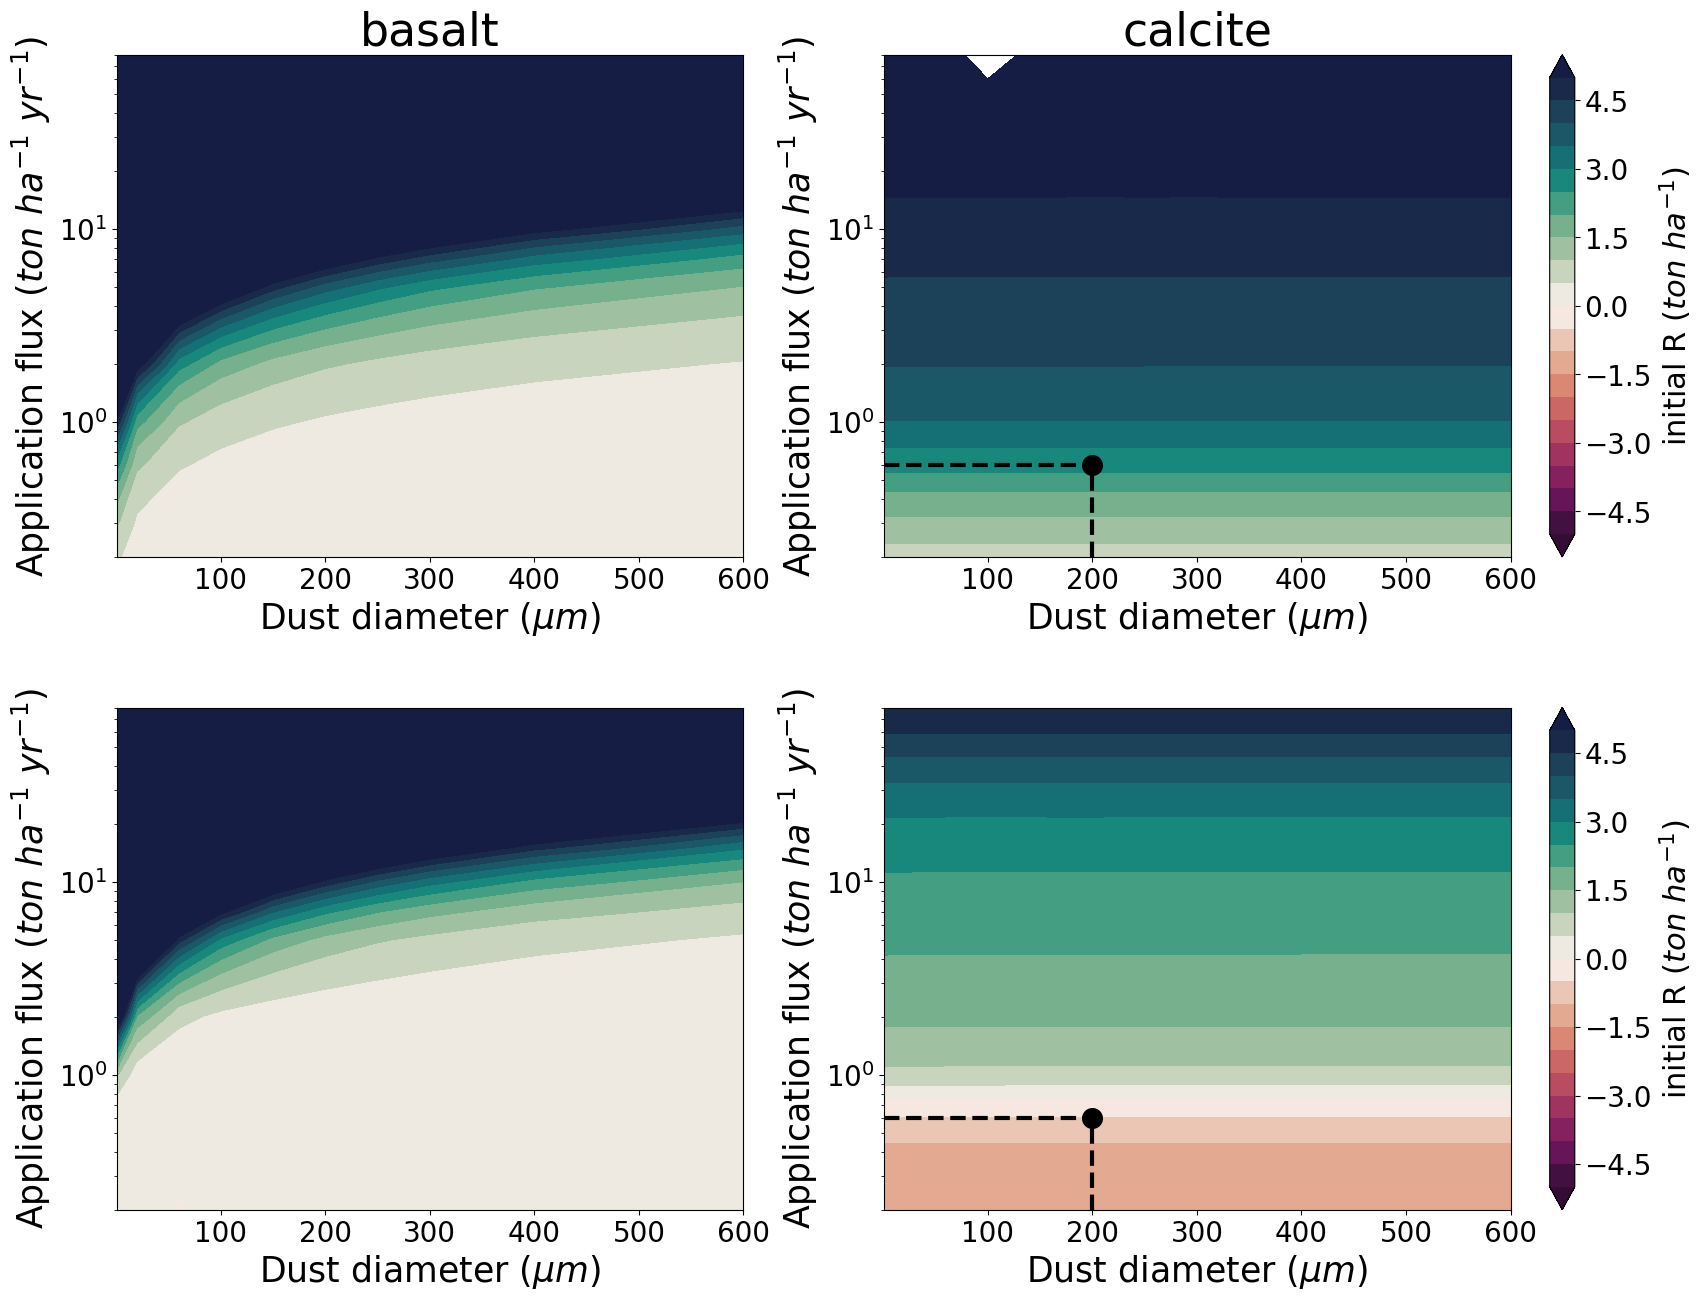

In [4]:
# --- PART 1: 4 panels of basalt and aglime R 
# set data conditions
cdr_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg'  # 'co2pot_tot_tonHa_camg'
loss_perc = 0
applevel_show = 12   # [1 | 2 | 12] which fertilizer levels to show
logX = False
logY = True
addLimeBaseline = True

# pull out the data we want
dssil1_p3 = dssil1.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dscc1_p3 = dscc1.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dssil2_p3 = dssil2.sel(loss_percent = loss_perc, method='nearest')[cdr_var]
dscc2_p3 = dscc2.sel(loss_percent = loss_perc, method='nearest')[cdr_var]

# get the lime baseline data
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values * 2

# # interpolate to fill nans (they're rare, 
# # but present in a couple cases where a run didn't complete)
dssil1_p3 = dssil1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc1_p3 = dscc1_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dssil2_p3 = dssil2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dscc2_p3 = dscc2_p3.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
include_titles = True
# color palette
col = cmo.curl_r
# lime baseline
ptsize = 200
ptcol = 'black'
lwd_base = 3
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 33    # plot title
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 1), 600
ymin, ymax = (0.2 if logY else 0), 80 
# *****************************

# x and y arrays
# [fertlevel 1, sil]
x1sil = dssil1_p3['dustrad'].values
y1sil = dssil1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 1, cc]
x1cc = dscc1_p3['dustrad'].values
y1cc = dscc1_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, sil]
x2sil = dssil2_p3['dustrad'].values
y2sil = dssil2_p3['dustrate_ton_ha_yr'].values
# [fertlevel 2, cc]
x2cc = dscc2_p3['dustrad'].values
y2cc = dscc2_p3['dustrate_ton_ha_yr'].values

# update index based on which ferts to show
if applevel_show == 1:
    spec_dx1 = 0
    spec_dx2 = 2
else:
    spec_dx1 = spec_dx2 = 0

# Define the midpoint normalization
# norm = TwoSlopeNorm(vmin=ds_anom[pvar].min(), vmax=ds_anom[pvar].max(), vcenter=0)
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=0)

# --- SET UP PLOT
# set up grid 
spec = GridSpec(ncols=2, nrows=2, hspace=0.3, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

if (applevel_show == 2) | (applevel_show == 12):
    # --- fertlevel 2 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[0-spec_dx2])
    contour = plt.contourf(x2sil*2,y2sil,dssil2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"Dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"Application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.title("basalt", fontsize=fs_title) if include_titles else "")
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    # --- cc
    ax = plt.subplot(spec[1-spec_dx2])
    contour = plt.contourf(x2cc*2,y2cc,dscc2_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    # contour_line = plt.contour(x2cc,y2cc,dscc2_p3.transpose(),levels=[0], colors='black', linewidths=2)
    # plt.axhline(y=50, color='darkgray', linestyle='dashed', linewidth=1)
    # ****
    if addLimeBaseline:
        plt.vlines(x=cf_dustrad, ymin=ymin, ymax=cf_apprate, colors=ptcol, linestyles='dashed', linewidths=lwd_base)    # vertical line
        plt.hlines(y=cf_apprate, xmin=xmin, xmax=cf_dustrad, colors=ptcol, linestyles='dashed', linewidths=lwd_base)    # horizontal line
        plt.scatter(cf_dustrad, cf_apprate, s=ptsize, c=ptcol)   # point
    # ****
    plt.xlabel(r"Dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"Application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.title("calcite", fontsize=fs_title) if include_titles else "")
    cbar = plt.colorbar(contour)
    cbar.set_label(r"initial R $(ton\ ha^{-1})$", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

if (applevel_show == 1) | (applevel_show == 12):
    # --- fertlevel 1 --------------------------------------------------------------------------
    # --- sil
    ax = plt.subplot(spec[2-spec_dx1])
    contour = plt.contourf(x1sil*2,y1sil,dssil1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    plt.xlabel(r"Dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"Application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    # (plt.title("basalt", fontsize=fs_title) if include_titles else "")
    plt.tick_params(axis='both', labelsize=fs_tick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    # --- cc
    ax = plt.subplot(spec[3-spec_dx1])
    contour = plt.contourf(x1cc*2,y1cc,dscc1_p3.transpose(), 
                            levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
    # contour_line = plt.contour(x1cc,y1cc,dscc1_p3.transpose(),levels=[0], colors='black', linewidths=2)
    # plt.axhline(y=50, color='darkgray', linestyle='dashed', linewidth=1)
    # ****
    if addLimeBaseline:
        plt.vlines(x=cf_dustrad, ymin=ymin, ymax=cf_apprate, colors=ptcol, linestyles='dashed', linewidths=lwd_base)    # vertical line
        plt.hlines(y=cf_apprate, xmin=xmin, xmax=cf_dustrad, colors=ptcol, linestyles='dashed', linewidths=lwd_base)    # horizontal line
        plt.scatter(cf_dustrad, cf_apprate, s=ptsize, c=ptcol)   # point
    # ****
    plt.xlabel(r"Dust diameter $(\mu m)$", fontsize=fs_xlab)
    plt.ylabel(r"Application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
    plt.tick_params(axis='both', labelsize=fs_tick)
    # (plt.title("aglime", fontsize=fs_title) if include_titles else "")
    cbar = plt.colorbar(contour)
    cbar.set_label(r"initial R $(ton\ ha^{-1})$", fontsize=fs_cbarlab)
    cbar.ax.tick_params(labelsize=fs_cbartick)
    (plt.xscale('log') if logX else "")
    (plt.yscale('log') if logY else "")
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

### Part 2: Vertical version

In [5]:
ds_anom1

<xarray.Dataset> Size: 4MB
Dimensions:                  (loss_percent: 50, dustrate_ton_ha_yr: 14,
                              dustrad: 10, cdr_calc: 5, feedstock: 2)
Coordinates:
  * loss_percent             (loss_percent) float64 400B 1.0 3.02 ... 100.0
  * dustrate_ton_ha_yr       (dustrate_ton_ha_yr) float64 112B 0.1 0.3 ... 100.0
  * dustrad                  (dustrad) int32 40B 1 10 30 50 ... 125 150 200 300
  * cdr_calc                 (cdr_calc) object 40B 'netR' ... 'conservative'
  * feedstock                (feedstock) object 16B 'cc' 'gbas'
Data variables:
    cdr_dif                  (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 560kB ...
    cdr_adv                  (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 560kB ...
    cdr_adv_plus_newSIC      (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 560kB ...
    cdr_SIConly              (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 560kB ...
    co2pot_tot_tonHa_camg    (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 560kB ...
    co2pot_adv_tonHa_camg    (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 560kB ...
    co2pot_tot_tonHa_totcat  (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 560kB ...
    co2pot_adv_tonHa_totcat  (feedstock, cdr_calc, dustrad, dustrate_ton_ha_yr, loss_percent) float64 560kB ...
    time_horizon             (feedstock) float64 16B ...
    cf_apprate               float64 8B 0.6
    cf_dustrad               int32 4B 100

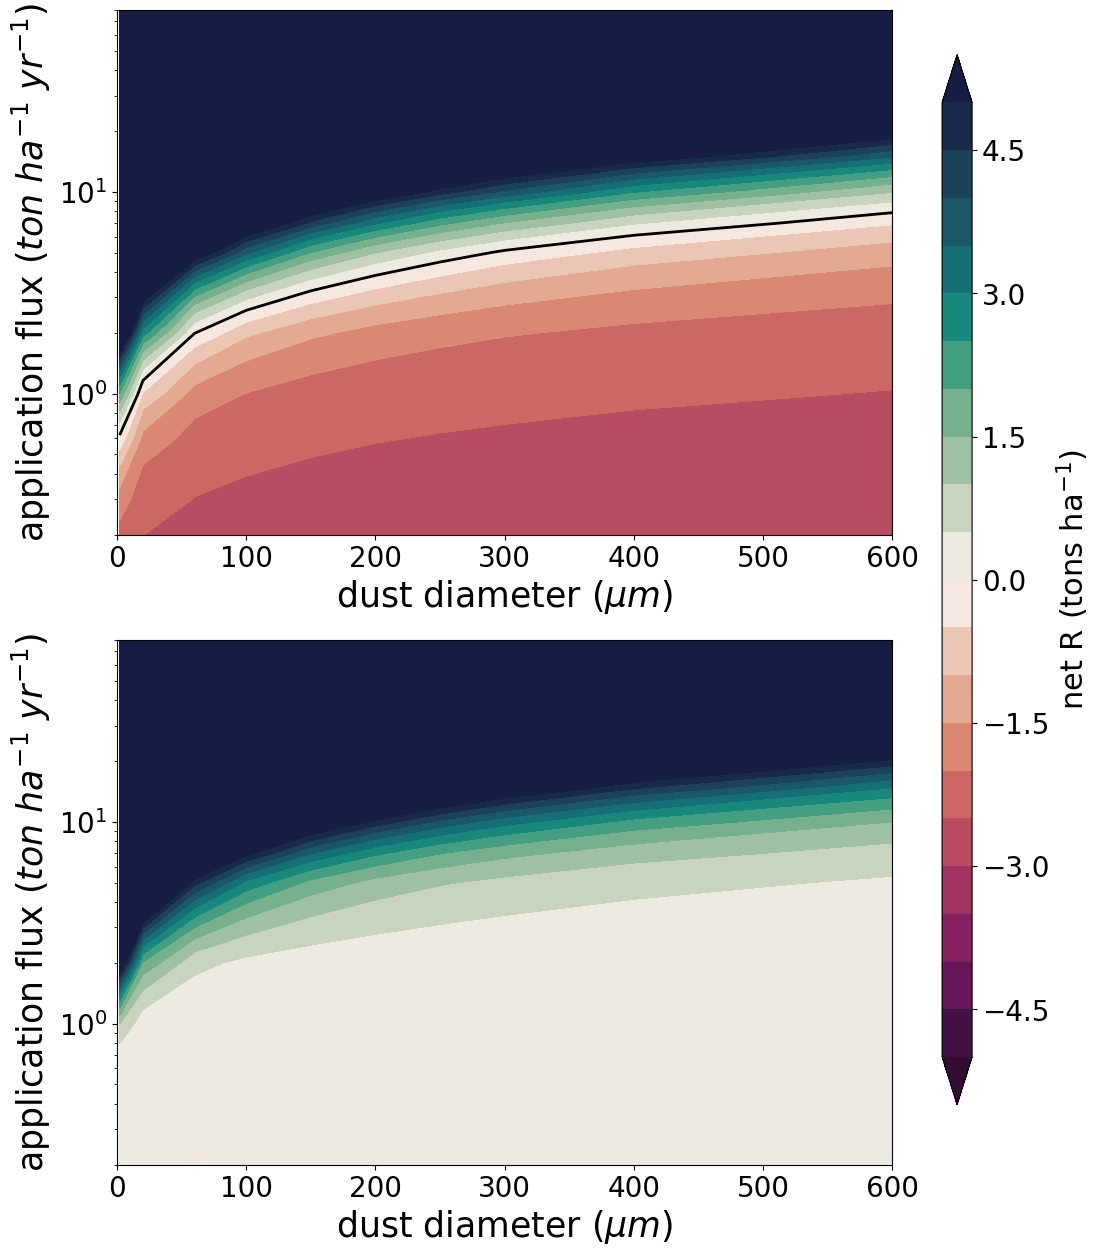

In [6]:
# --- PLOT --------------------
# set data conditions
feedstock = 'gbas'
cdr_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg'  # 'co2pot_tot_tonHa_camg'
loss_percent = 0
cdr_calc = 'netR_noNeg'
logX = False
logY = True

# pull out the data we want
dsanom1_p4 = ds_anom1.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
dsanom2_p4 = ds_anom2.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsanom1_p4 = dsanom1_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom2_p4 = dsanom2_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col = cmo.curl_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 80 
# *****************************

# x and y arrays
# [fertlevel 1]
x1 = dsanom1_p4['dustrad'].values
y1 = dsanom1_p4['dustrate_ton_ha_yr'].values
# [fertlevel 2]
x2 = dsanom2_p4['dustrad'].values
y2 = dsanom2_p4['dustrate_ton_ha_yr'].values

# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values


# --- SET UP PLOT
spec = GridSpec(ncols=1, nrows=2, hspace=0.2)
fig = plt.figure(figsize=(10,15))

# --- fertlevel 1
ax = plt.subplot(spec[1])
contour = plt.contourf(x1*2,y1,dsanom1_p4.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1*2,y1,dsanom1_p4.transpose(),levels=[-0.01], linestyles='solid', colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.suptitle(f"netCDR basalt — aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
# plt.title(f"\n{fertLevel_1} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- fertlevel 2
ax = plt.subplot(spec[0])
contour = plt.contourf(x2*2,y2,dsanom2_p4.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x2*2,y2,dsanom2_p4.transpose(),levels=[-0.01], linestyles='solid', colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.title(f"\n{fertLevel_2} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
cbar = plt.colorbar(contour, cax=cbar_ax)
cbar.set_label(r"$\text{net R}\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.yscale('log')


### Part 2: horizontal version

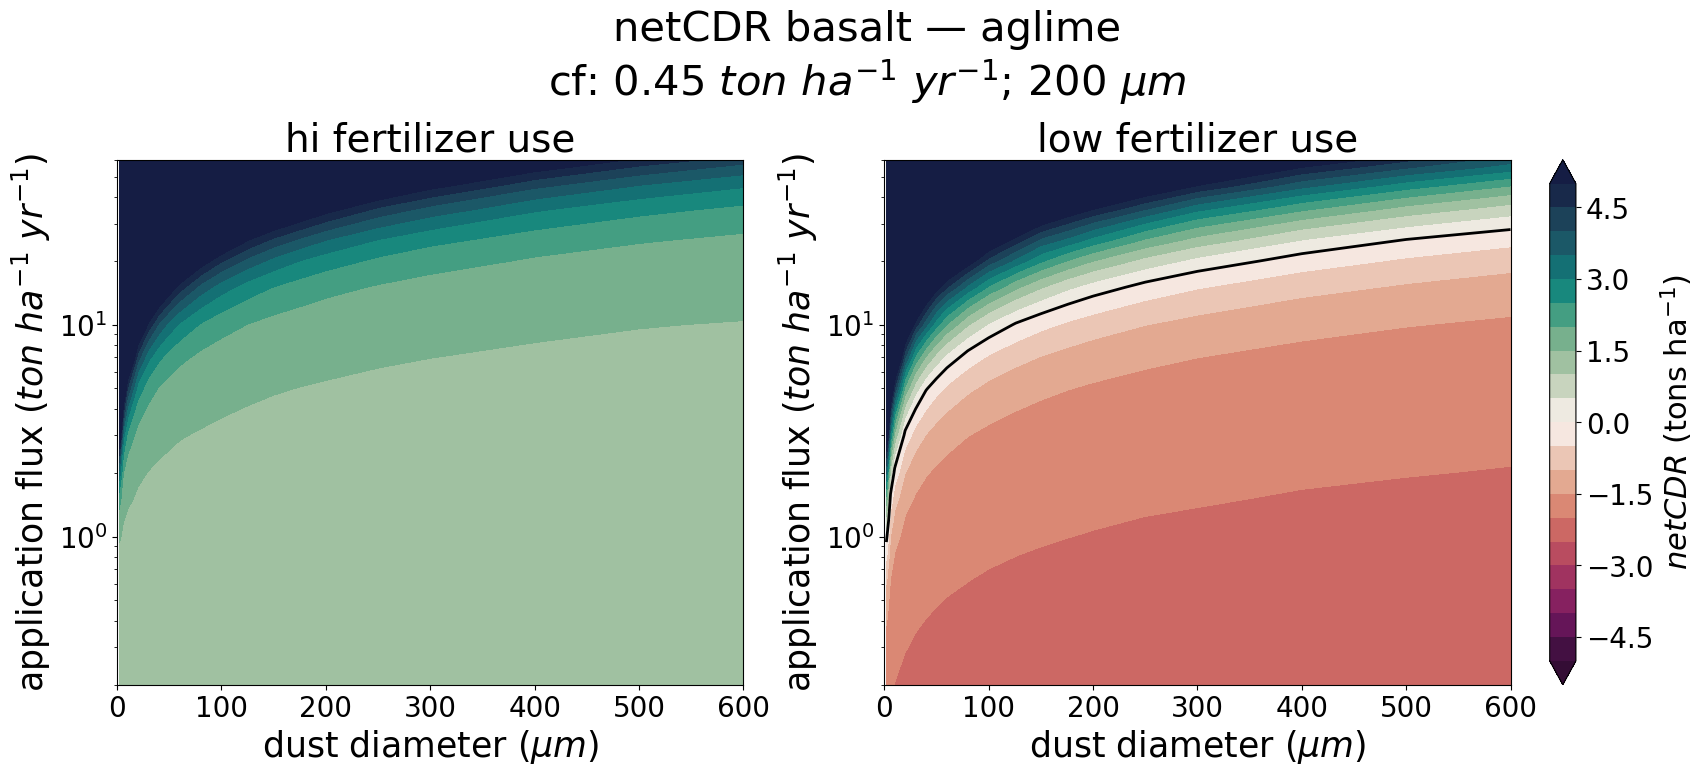

In [18]:
# --- PLOT --------------------
# set data conditions
feedstock = 'gbas'
cdr_var = 'cdr_dif' # 'co2pot_adv_tonHa_camg' 
loss_percent = 0
cdr_calc = 'netR'
logX = False
logY = True

# pull out the data we want
dsanom1_p4 = ds_anom1.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]
dsanom2_p4 = ds_anom2.sel(feedstock=feedstock, cdr_calc=cdr_calc).sel(loss_percent=loss_percent, method='nearest')[cdr_var]

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsanom1_p4 = dsanom1_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
dsanom2_p4 = dsanom2_p4.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col = cmo.curl_r
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = -5, 5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 600
ymin, ymax = (0.2 if logY else 0), 60 
# *****************************

# x and y arrays
# [fertlevel 1]
x1 = dsanom1_p4['dustrad'].values
y1 = dsanom1_p4['dustrate_ton_ha_yr'].values
# [fertlevel 2]
x2 = dsanom2_p4['dustrad'].values
y2 = dsanom2_p4['dustrate_ton_ha_yr'].values

# pull out cf dustrate and dustrad
cf_apprate = ds_anom1.cf_apprate.values
cf_dustrad = ds_anom1.cf_dustrad.values


# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

# --- fertlevel 1
ax = plt.subplot(spec[0])
contour = plt.contourf(x1*2,y1,dsanom1_p4.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1*2,y1,dsanom1_p4.transpose(),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.suptitle(f"netCDR basalt — aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
plt.title(f"\n{fertLevel_1} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# --- fertlevel 2
ax = plt.subplot(spec[1])
contour = plt.contourf(x2*2,y2,dsanom2_p4.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x2*2,y2,dsanom2_p4.transpose(),levels=[0], colors='black', linewidths=2)
plt.xlabel(r"dust diameter $(\mu m)$", fontsize=fs_xlab)
plt.ylabel(r"application flux $(ton\ ha^{-1}\ yr^{-1})$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
plt.title(f"\n{fertLevel_2} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(r"$netCDR\ (\text{tons}\ \text{ha}^{-1})$", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)
# plt.yscale('log')


In [ ]:
# -----